<a href="https://colab.research.google.com/github/fodothing/ImprovedWord2Vec/blob/main/TextGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prerequisites

One layer GAT as a classification method used in paper "Improving Text Classification Performance with Word Embedding Model Based on Graph Attention Neural Network"

In [1]:
# Import Libraries
import os
import re
import dgl
import nltk
import time
import math
import pickle
import random
import word2vec
import numpy as np
import torch as th
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from gensim.models import FastText
from gensim.models import Word2Vec
from torch.nn import functional as F
from sklearn.model_selection import train_test_split  # for train and dev set split


'''
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
'''
from dgl.nn import GATConv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize




# Set Random Seed
SEED = 42
th.manual_seed(SEED)
th.cuda.manual_seed(SEED)
random.seed(SEED)

# Set Common Path
COMMON_PATH = "/Users/hshuaifile"

D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#Dataset Preprocessing

##Clean Text

Just run it once.

In [ ]:
# Clean Data
def Clean_Text(string):
  """
  Tokenization/string cleaning for all datasets except for SST.
  Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
  """
  string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
  string = re.sub(r"\'s", " \'s", string)
  string = re.sub(r"\'ve", " \'ve", string)
  string = re.sub(r"n\'t", " n\'t", string)
  string = re.sub(r"\'re", " \'re", string)
  string = re.sub(r"\'d", " \'d", string)
  string = re.sub(r"\'ll", " \'ll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " \( ", string)
  string = re.sub(r"\)", " \) ", string)
  string = re.sub(r"\?", " \? ", string)
  string = re.sub(r"\s{2,}", " ", string)
  
  return string.strip().lower()

def Clean_and_Save(path, dataset_name):
  NAME = dataset_name
  if NAME not in ['20ng', 'r8', 'r52', 'oh', 'mr']:
    raise ValueError('The dataset is not support')
  raw_x = []
  with open(os.path.join(path, NAME+'.txt'), "r", encoding='latin1') as f:
    data = f.readlines()
    print(f'{NAME}, Total sample: {len(data)}')
  with open(os.path.join(path, NAME+'_mapping.txt'), "r", encoding='latin1') as f:
    map = f.readlines()
    print(f'{NAME}, Total mapping: {len(map)}')
  if len(map) != len(data):
    raise Exception('Map size not equal to data')
  
  # Clean Sample and Save
  tra_x, tra_y = [], []
  tes_x, tes_y = [], []
  for i in range(len(map)):
    cle_x = Clean_Text(data[i]).strip()  # X
    lab = map[i].split('\t')  # y
    if lab[len(lab)-2] in ['20news-bydate-test', 'test']:
      tes_x.append(cle_x)
      tes_y.append(re.sub(r'\n', '', lab[len(lab)-1]))
    elif lab[len(lab)-2] in ['20news-bydate-train', 'train', 'training']:
      tra_x.append(cle_x)
      tra_y.append(re.sub(r'\n', '', lab[len(lab)-1]))
  if len(tes_y)!=len(tes_x) or len(tra_x)!=len(tra_y):
    raise Exception('Numbef of x is not equal y')
  
  print(f'Total train: {len(tra_x)}')
  print(f'Total test: {len(tes_x)}')

  # Save to csv
  df_tra = pd.DataFrame({'tra_y': tra_y, 'tra_x': tra_x})
  df_tes = pd.DataFrame({'tes_y': tes_y, 'tes_x': tes_x})
  # Remove the csv header
  df_tra.columns = range(df_tra.shape[1])
  df_tes.columns = range(df_tes.shape[1])
  df_tra.to_csv(f'{COMMON_PATH}/TextLevelGNN/data/{NAME}-stemmed.txt', index=False, sep='\t',header=None)
  df_tes.to_csv(f'{COMMON_PATH}/TextLevelGNN/data/{NAME}-test-stemmed.txt', index=False, sep='\t',header=None)

path = f'{COMMON_PATH}/TextLevelGNN/data/'
for name in ['20ng', 'r8', 'r52', 'oh', 'mr']:
  t0 = time.time()
  #if name not in ["oh"]: continue  # Check for specific dataset 
  Clean_and_Save(path, name)
  print(f'Time: {time.time() - t0:.4f}s')
  print('='*50)


20ng, Total sample: 18846
20ng, Total mapping: 18846
Total train: 11314
Total test: 7532
Time: 2.9094s
r8, Total sample: 7674
r8, Total mapping: 7674
Total train: 5485
Total test: 2189
Time: 0.4574s
r52, Total sample: 9100
r52, Total mapping: 9100
Total train: 6532
Total test: 2568
Time: 0.5386s
oh, Total sample: 7400
oh, Total mapping: 7400
Total train: 3357
Total test: 4043
Time: 1.0318s
mr, Total sample: 10662
mr, Total mapping: 10662
Total train: 7108
Total test: 3554
Time: 0.3685s


##Convert to Token

Text to Token

In [2]:
# Build Vocab on All Train Sample
def BuildVocab(TrainSample, min_count):
  freq = {}
  for x in TrainSample:
    for t in word_tokenize(x):
      if t not in freq:
        freq[t] = 0
      else:
        freq[t] += 1
  del_key = []
  for i in freq:
    if freq[i]<min_count:
      del_key.append(i)
  
  for i in del_key:freq.pop(i)

  vocab_id = {}
  for i, key in enumerate(freq): vocab_id[key] = i
  vocab_id["_unk_"] = i+1  # Unknow word index (OOV)

  print(f'vocab_size={len(vocab_id)}, min_count={min_count}')
  print('='*50)

  return vocab_id


# Convert Word to ID Number
def X2Id(X, vocab):
  ids = []
  for w in word_tokenize(X):
    if w in vocab:
      ids.append(vocab[w])
    else:
      ids.append(vocab["_unk_"])
  
  return ids


# Convert String Tex to Token Number
def Text2Token(vocab, text_list):
  temp = []
  for text in text_list:
    temp.append(X2Id(text, vocab))
  
  return temp


# Split Train and Dev Set
def Tra_Dev_Set(all_train_text, all_train_label, dataset_name):
  if dataset_name=="r52":
    train_x, dev_x, train_y, dev_y = train_test_split(all_train_text, all_train_label, test_size=0.06, shuffle=True, random_state=42)
  else:
    train_x, dev_x, train_y, dev_y = train_test_split(all_train_text, all_train_label, \
                                                      test_size=0.1, shuffle=True, random_state=42, stratify=all_train_label)

  return train_x, dev_x, train_y, dev_y


# Shuffle All Train Sample, Split and Token
def MyDataset(dataset_name):
  NAME = dataset_name
  if NAME not in ['20ng', 'r8', 'r52', 'oh', 'mr']:
    raise ValueError('The dataset is not support')
  
  frame = {"all_train_text":[], "all_train_label":[], "test_text":[], "test_label":[]}
  PATH = f'{COMMON_PATH}/TextLevelGNN/data/'
  for t1,t2,t3 in [("-stemmed.txt", "all_train_text", "all_train_label"),
                      ("-test-stemmed.txt", "test_text", "test_label")]:
    with open(os.path.join(PATH, NAME+t1), 'r') as f:
      data = f.readlines()
      for line in data:
        line = line.strip()
        temp = line.split('\t')
        frame[t2].append(temp[1])  # X
        frame[t3].append(temp[0])  # y
    
  train_text, dev_text, train_label, dev_label = Tra_Dev_Set(frame["all_train_text"], frame["all_train_label"], NAME)
  test_text, test_label = frame["test_text"], frame["test_label"]
  
  num_class = list(set(train_label))  # len(num_class)
  label2idx = {label: idx for idx, label in enumerate(num_class)}
  print(f'Dataset={NAME}, Num_class={len(num_class)}, labels={label2idx}')
  print(f'All_train={len(frame["all_train_text"])}, Train_size={len(train_text)}, Dev_size={len(dev_text)}, Test_size={len(test_text)}')

  min_count = {'20ng':4, 'r8':4, 'r52':4, 'oh':4, 'mr':1}  # Min count for building vocab
  vocab = BuildVocab(train_text, min_count[NAME])
  train_text_tok = Text2Token(vocab, train_text)
  dev_text_tok = Text2Token(vocab, dev_text)
  test_text_tok = Text2Token(vocab, test_text)

  train_label_tok = [label2idx[t] for t in train_label]
  dev_label_tok = [label2idx[t] for t in dev_label]
  test_label_tok = [label2idx[t] for t in test_label]

  
  return train_text_tok,  train_label_tok, dev_text_tok, dev_label_tok, \
          test_text_tok, test_label_tok, len(num_class), vocab

# Model Architecture

In [ ]:
# Model Architecture
class GATLayer(th.nn.Module):
  def __init__(self, in_dim, hidden_dim):
    super(GATLayer, self).__init__()
    self.feat_drop = 0.2
    self.attn_drop = 0.2
    self.gat_layer = GATConv(in_dim, hidden_dim, 2, self.feat_drop, self.attn_drop, activation=F.elu)

  def forward(self, g, inputs):
    inputs = self.gat_layer(g, inputs)
    h = inputs.mean(1)
    
    return h


class MyModel(th.nn.Module):
  def __init__(self, vocab, in_dim, hidden_dim, num_class, device):
    super(MyModel, self).__init__()
    self.gram = 6
    self.vocab = vocab
    self.num_class = num_class
    self.device = device
    self.max_length = 300
    self.vocab_size = len(vocab)
    self.node_hidden = th.nn.Embedding(self.vocab_size, in_dim)

    self.node_hidden.weight.data.copy_(
        th.tensor(self.Load_w2v(f"{COMMON_PATH}/Word2Vec/data/trainedembedding/skipgram_300_100.model")))
    self.node_hidden.weight.requires_grad = True
      
    self.gat = GATLayer(in_dim, hidden_dim)
    self.lin1 = th.nn.Linear(hidden_dim*3, num_class)

  def Load_w2v(self, path):
    #model1 = FastText.load(path)
    model1 = Word2Vec.load(path)
    #model1 = th.load(path)
    #with open(f"{COMMON_PATH}/Word2Vec/data/trainedembedding/myw2v_300_100.pickle", 'rb') as handle:
    #  myword2idx = pickle.load(handle)

    embedding_matrix = []
    unk_d = len(model1.wv['the'])  # Unknow word dimension
    #unk_d = len(model1[myword2idx['the']])  # Unknow word dimension
    for word in self.vocab:
      try:
        embedding_matrix.append(model1.wv[word])
        #embedding_matrix.append(model1[myword2idx[word]])
      except KeyError:
        embedding_matrix.append(np.zeros(unk_d))
    
    return np.array(embedding_matrix)


  def AddEdges(self, n):  # For Pooling graph
    edges = []
    for i in range(n):
      for j in range(max(0, i-self.gram), min(i + self.gram + 1, n)):  # Directed graph
        edges.append([i, j])
    
    return edges


  def BuildGraph(self, sample):
    t = len(sample)
    if t == 0: raise Exception('sample length is equal 0')
    if t > self.max_length: sample = sample[:self.max_length]
    n = len(sample)
    u, v = zip(*self.AddEdges(n))
    g = dgl.graph((u, v), num_nodes=n).to(self.device)
    sample_index = th.tensor(sample).to(self.device)
    g.ndata['h'] =  self.node_hidden(sample_index)

    return g
  
  def BatchCat(self, g:list, gat):
    batch_g = dgl.batch(g)
    batch_g.ndata['h'] = gat(batch_g, batch_g.ndata['h']) # Update node embedding
    out1 = dgl.mean_nodes(batch_g, feat='h')
    out2 = dgl.max_nodes(batch_g, feat='h')
    out3 = dgl.sum_nodes(batch_g, feat="h")
    output = th.cat([out1,out2, out3], dim=1)

    return output

  def forward(self, sample): 
    g = []
    for t in sample:
      g.append(self.BuildGraph(t))  # One batch size graphs
    out = self.BatchCat(g, self.gat)
    out = self.lin1(out)
    score = F.log_softmax(out, dim=-1)  # Score on each class
    
    return score


#Model Train and Test

In [ ]:
# Train Function
def Train(model, epoch, train_X, train_y, dev_X, dev_y, device, dataset_name):
  optimizer = th.optim.AdamW(model.parameters(), weight_decay=1e-2, lr=2e-4)
  PATIENCE = 6  # Patience on dev set to stop training
  no_improve = 0
  best_acc = 0.0
  all_loss = []
  all_dev_acc = []
  all_epo = []
  for e in range(epoch):
    improved = ''
    model.train()
    for batch_X, batch_y in zip(train_X, train_y):
      batch_y = batch_y.to(device)
      optimizer.zero_grad()  # Clear gradient
      score = model(batch_X)
      loss = F.nll_loss(score, batch_y)
      #loss += 0.5*optimizer.param_groups[0]['weight_decay']*th.norm(model.lin1.weight)  # L2 norm
      loss.backward()  # Derive gradient
      optimizer.step()  # Update gradient
    #train_acc = Dev(model, train_X, train_y, device)
    dev_acc = Dev(model, dev_X, dev_y, device)
    if dev_acc>best_acc:
      best_acc = dev_acc
      no_improve = 0
      improved = '*'
      th.save(model, f'{COMMON_PATH}/TextLevelGNN/model/MyModel.pkl')
    else: 
      no_improve+=1
    all_loss.append(loss.item())
    all_dev_acc.append(dev_acc.cpu().numpy())
    all_epo.append(e)
    if e%2 == 0:
      print(f'Epoch={e+1}/{epoch}, Train_loss={loss.item():.4f}, Dev_acc={dev_acc:.4f}, {improved}')
    if no_improve>=PATIENCE:
      print(f'No improvement on dev set, early stopping.')
      break
  now_time = datetime.now()
  t = re.sub(r' |:|\.', '-', str(now_time))
  df = pd.DataFrame({"epoch":all_epo, "loss":all_loss, "dev_acc":all_dev_acc})
  df.to_csv(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc/{dataset_name}-loss-{t}.csv", index=False)


# Dev Function
def Dev(model, X, y, device):
  model.eval()
  total = 0.0
  correct = 0.0
  for batch_X, batch_y in zip(X, y):
    batch_y = batch_y.to(device)

    with th.no_grad():
      score = model(batch_X)
      pred = th.argmax(score, dim=1)
      correct += th.sum(pred==batch_y)
      total += len(batch_y)

  return th.div(correct, total)


# Test Function (Same as Dev)
def Test(model, X, y, device):
  model.eval()
  total = 0.0
  correct = 0.0
  for batch_X, batch_y in zip(X, y):
    batch_y = batch_y.to(device)

    with th.no_grad():
      score = model(batch_X)
      pred = th.argmax(score, dim=1)
      correct += th.sum(pred==batch_y)
      total += len(batch_y)

  return th.div(correct, total)


#Run Experiment

In [ ]:
# Batch the Dataset
def Batch(X, y, batch_size=64, shuffle=False):
  data = [(X[i], y[i]) for i in range(len(y))]
  if shuffle:
    random.shuffle(data)
    X = [t for t,_ in data]  # Shuffled X
    y = [t for _,t in data]  # Shuffled y 
  batched_X = [X[i:i+batch_size] for i in range(0, len(data), batch_size)]
  batched_y = [th.tensor(y[i:i+batch_size]) for i in range(0, len(data), batch_size)]
  
  return batched_X, batched_y


# Save Experiment Result (Acuuracy and Running Time)
def SaveResult(acc, time, dataset_name):
  df1 = pd.DataFrame({"Acc": acc})
  df2 = pd.DataFrame({"Time": time})
  df1.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Acc-{dataset_name}.csv', index=False)
  df2.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Time-{dataset_name}.csv', index=False)


def MeanAcc(dataset_name):
  acc_mean = []
  acc_std = []
  for name in dataset_name:
    df = pd.read_csv(f'{COMMON_PATH}/TextLevelGNN/model/Acc-{name}.csv')
    acc = df["Acc"].iloc[0:]
    acc_mean.append(np.mean(acc))
    acc_std.append(np.std(acc))

  return acc_mean, acc_std


def MeanTime(dataset_name):
  mean_time = []
  for name in dataset_name:
    df = pd.read_csv(f'{COMMON_PATH}/TextLevelGNN/model/Time-{name}.csv')
    time = df["Time"].iloc[0:]
    mean_time.append(np.mean(time))
    
  return mean_time


# Save Average Result for All Dataset
def SaveTotalResult(dataset):
  my_acc, my_std = MeanAcc(dataset)
  my_time = MeanTime(dataset)
  print(f"acc_mean={my_acc}")
  print(f"acc_std={my_std}")
  print(f"time_mean(m)={my_time}")
  now_time = datetime.now()
  t = re.sub(r' |:|\.', '-', str(now_time))
  df = pd.DataFrame({"dataset":dataset, "acc_mean":my_acc, "acc_std":my_std, "time_mean(m)":my_time})
  df.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Total-result{t}.csv', index=False)


# Set Training Device
DEVICE = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
if th.cuda.is_available():
  print(f'device: {DEVICE}')
  print(f'name: {th.cuda.get_device_name(0)}')
  print(f'='*50)

# Set Constant
shuffle_time = 1
run_time = 5  # Run n times to get average
epoch=200
dataset = ['20ng', 'r8',  'r52', 'oh', 'mr']

#remove old  training loss data before new run
!rm /Users/hshuaifile/TextLevelGNN/model/loss_acc/*

print("="*50)
all_time_start = time.time()
for NAME in dataset:
  #if NAME not in ["oh"]: continue  # Check for specific dataset
  all_acc = []
  consume_time = []
  for s in range(shuffle_time):
    train_text_tok, train_label_tok, dev_text_tok, dev_label_tok, test_text_tok, test_label_tok, num_class, vocab = MyDataset(NAME)
    dev_X, dev_y = Batch(dev_text_tok, dev_label_tok)
    test_X, test_y = Batch(test_text_tok, test_label_tok)
    for i in range(run_time):
      train_X, train_y = Batch(train_text_tok, train_label_tok, shuffle=True)  # Shuffle train dataset run n times to get average
      t0 = time.time()
      row_model = MyModel(vocab, 300, 300, num_class, DEVICE)
      row_model.to(DEVICE)
      Train(row_model, epoch, train_X, train_y, dev_X, dev_y, DEVICE, NAME)
      trained_model = th.load(f'{COMMON_PATH}/TextLevelGNN/model/MyModel.pkl', map_location=DEVICE)
      acc = Test(trained_model, test_X, test_y, DEVICE).cpu().numpy()
      print(f'{NAME}, ShuffleTime={s+1}/{shuffle_time}, RunTime={i+1}/{run_time}, Test_acc={acc:.4f}, Ave_Epoch_Time={(time.time()-t0)/epoch:.1f}s, All_Epoch_Time={(time.time()-t0)/60:.1f}m')
      all_acc.append(acc)
      consume_time.append((time.time()-t0)/60)
      print("="*50)
    print("="*100)
  SaveResult(all_acc, consume_time, NAME)

SaveTotalResult(dataset)
print("="*50)
print(f"All Time Use: {(time.time()-all_time_start)/3600:.1f}h")

device: cuda:0
name: NVIDIA GeForce RTX 3090
Dataset=20ng, Num_class=20, labels={'comp.sys.mac.hardware': 0, 'rec.motorcycles': 1, 'sci.space': 2, 'rec.sport.baseball': 3, 'rec.sport.hockey': 4, 'alt.atheism': 5, 'sci.crypt': 6, 'comp.os.ms-windows.misc': 7, 'sci.med': 8, 'comp.sys.ibm.pc.hardware': 9, 'sci.electronics': 10, 'talk.religion.misc': 11, 'rec.autos': 12, 'talk.politics.guns': 13, 'talk.politics.mideast': 14, 'soc.religion.christian': 15, 'comp.windows.x': 16, 'misc.forsale': 17, 'talk.politics.misc': 18, 'comp.graphics': 19}
All_train=11314, Train_size=10182, Dev_size=1132, Test_size=7532
vocab_size=30270, min_count=4
Epoch=1/200, Train_loss=1.7588, Dev_acc=0.5027, *
Epoch=3/200, Train_loss=0.4699, Dev_acc=0.8534, *
Epoch=5/200, Train_loss=0.0869, Dev_acc=0.9134, *
Epoch=7/200, Train_loss=0.0287, Dev_acc=0.9170, *
Epoch=9/200, Train_loss=0.0103, Dev_acc=0.9187, *
Epoch=11/200, Train_loss=0.0036, Dev_acc=0.9178, 
Epoch=13/200, Train_loss=0.0028, Dev_acc=0.9187, 
Epoch=15/20

# Result Plot

## Acc Plot

Model performance on test set.

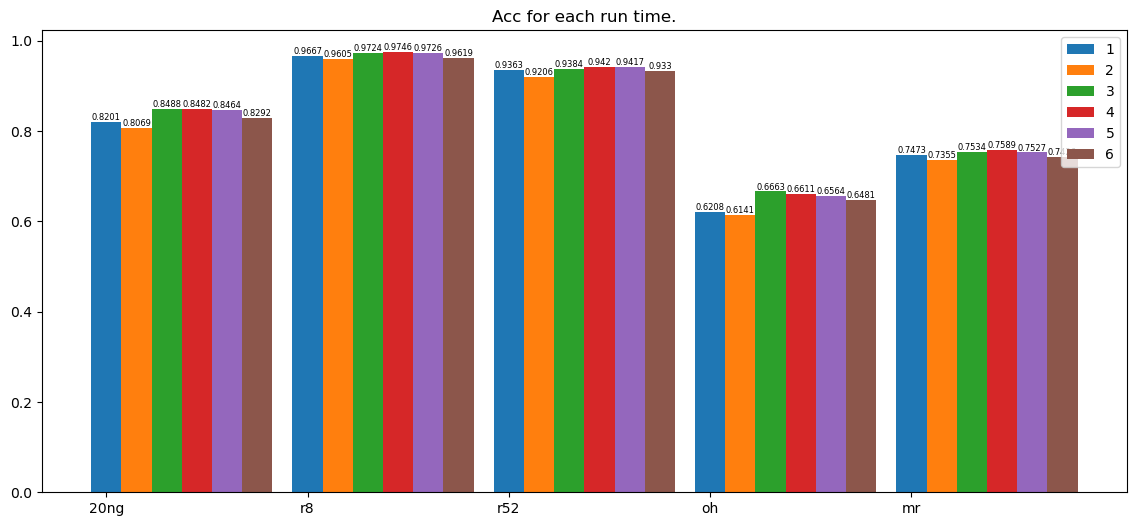

In [ ]:
def ShowAllResult():
  all_acc_mean, all_acc_time, all_acc_std = [], [], []
  all_file = os.listdir(f"{COMMON_PATH}/TextLevelGNN/model/")
  for t in all_file:
    if t.startswith("Total-result"):
      df = pd.read_csv(f"{COMMON_PATH}/TextLevelGNN/model/{t}")
      all_acc_mean.append(df["acc_mean"])
      all_acc_time.append(df["time_mean(m)"])
      all_acc_std.append(df["acc_std"])
      #break
  
  return all_acc_mean, all_acc_std, all_acc_time

dataset = ['20ng', 'r8',  'r52', 'oh', 'mr']     
all_acc_mean, all_acc_std, all_acc_time = ShowAllResult()

fig = plt.figure(figsize=(14,6),dpi=100)

ax1 = fig.add_subplot(111)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_mean)):
  x = x_length+i*bar_width
  y = all_acc_mean[i]
  ax1.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax1.text(a, b, round(b,4), ha="center", va="bottom", fontsize=6)
plt.xticks(x_length, dataset)
plt.title("Acc for each run time.")

ax1.legend()

plt.show()


## Time, Std

Running time, standard variances of accuracy on test set.

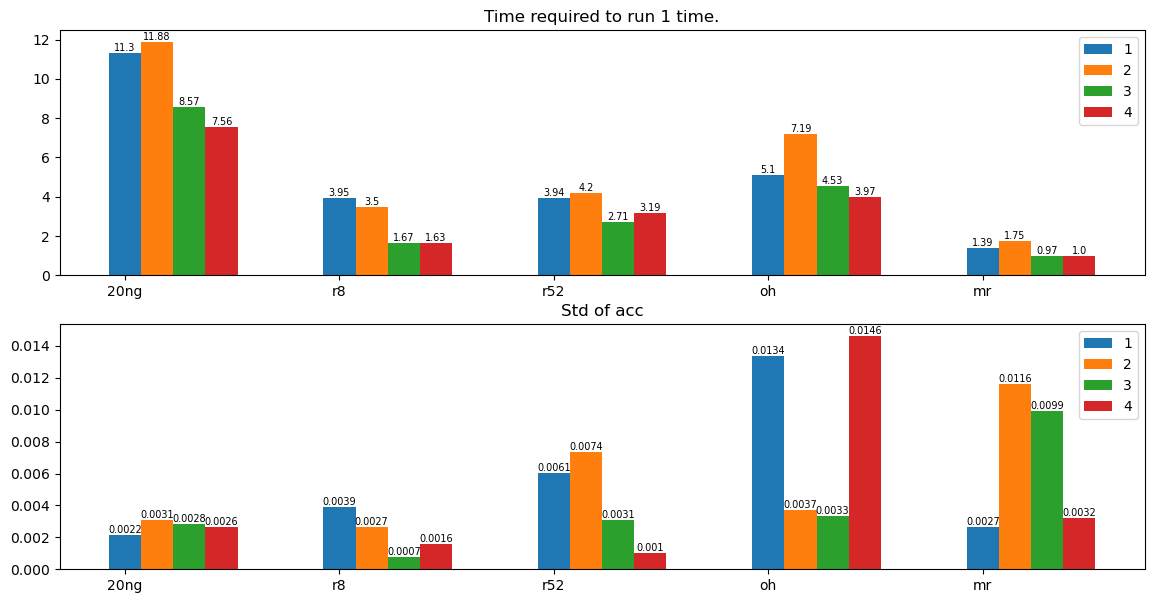

In [ ]:
fig = plt.figure(figsize=(14,7), dpi=100)

ax1 = fig.add_subplot(211)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_time)):
  x = x_length+i*bar_width
  y = all_acc_time[i]
  ax1.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax1.text(a, b, round(b,2), ha="center", va="bottom", fontsize=7)
plt.xticks(x_length, dataset)
plt.title("Time required to run 1 time.")
ax1.legend()

ax2 = fig.add_subplot(212)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_std)):
  x = x_length+i*bar_width
  y = all_acc_std[i]
  ax2.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax2.text(a, b, round(b,4), ha="center", va="bottom", fontsize=7)
plt.xticks(x_length, dataset)
plt.title("Std of acc")
ax2.legend()

plt.show()

## Loss, Dev Acc

Training loss, accuracy on dev set.

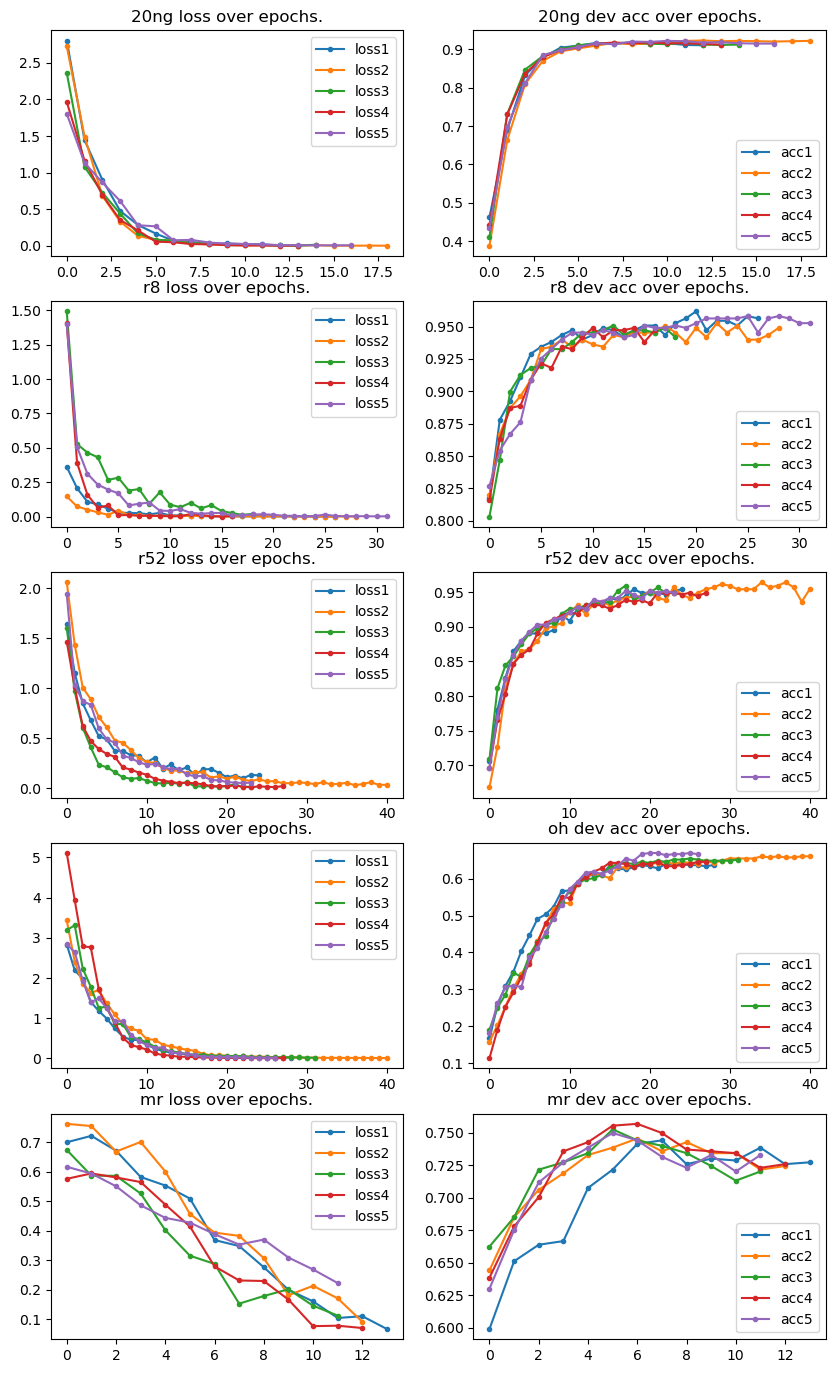

In [ ]:
def ReadAllResult(dataset_name):
  all_epoch, all_loss, all_dev_acc = [], [], []
  all_file = os.listdir(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc")
  for t in all_file:
    if t.startswith(dataset_name):
      df = pd.read_csv(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc/{t}")
      all_epoch.append(df["epoch"])
      all_loss.append(df["loss"])
      all_dev_acc.append(df["dev_acc"])
  
  return all_epoch, all_loss, all_dev_acc

# Loss, Dev Acc over epochs
fig = plt.figure(figsize=(10,17), dpi=100)
dataset_name = ["20ng", "r8", "r52", "oh", "mr"]

for index, name in enumerate(dataset_name):
  all_epoch, all_loss, all_dev_acc = ReadAllResult(name)
  ax2 = fig.add_subplot(5, 2, 2*index+1)
  for i in range(len(all_loss)):
    ax2.plot(all_epoch[i], all_loss[i], '.-', label=f"loss{i+1}")
  ax2.legend()
  plt.title(f"{name} loss over epochs.")

  ax3 = fig.add_subplot(5, 2, 2*index+2)
  for i in range(len(all_dev_acc)):
    ax3.plot(all_epoch[i], all_dev_acc[i], '.-', label=f"acc{i+1}")
  ax3.legend()
  plt.title(f"{name} dev acc over epochs.")

#plt.savefig(f"{COMMON_PATH}/Word2Vec/model/fig/alldataset_trainloss_CBOW300d100a.pdf", bbox_inches="tight")
plt.show()

## Compare Baseline

In [ ]:
name = ["20NG", "R8","R52","Ohsumed","MR"]
TextGCN = [86.34, 97.07, 93.56, 68.36, 76.74]
TextLevelGCN = [None, 97.8, 94.6, 69.94, None]
my_model_acc = [85.03, 97.91, 95.37, 68.73, 77.45]


# Baseline method
BERT = [85.3, 97.8, 96.4, 70.5, 85.7]
ROBERTa = [83.8, 97.8, 96.2, 70.7, 89.4]
BertGCN = [89.3, 98.1, 96.6, 72.8, 86.0]
RoBERTaGCN = [89.5, 98.2, 96.1, 72.8, 89.7]
BertGAT = [87.4, 97.8, 96.5, 71.2, 86.5]
RoBERTaGAT = [86.5, 98.0, 96.1, 71.2, 89.2]
BERTHieGAT = [85.05, 97.83, 96.57, 70.71, 86.03]
RoBERTaHieGAT = [85.38, 98.05, 96.13, 72.49, 89.21]

fig = plt.figure(figsize=(12,7),dpi=100)
ax1 = fig.add_subplot(121)
ax1.plot(name, TextGCN, '-', label="TextGCN")
ax1.plot(name, my_model_acc, '.-', label="MyModel")
ax1.plot(name, TextLevelGCN, ".--", label="TextLevelGCN")
plt.title("Compare acc with pure GNNs models.")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(name, BertGCN, '-', label="BertGCN")
ax2.plot(name, RoBERTaGCN, '.-', label="RoBERTaGCN")
ax2.plot(name, BertGAT, '-.', label="BertGAT")
ax2.plot(name, RoBERTaGAT, '--', label="RoBERTaGAT")
ax2.plot(name, BERTHieGAT, '^-', label="BERTHieGAT")
ax2.plot(name, RoBERTaHieGAT, '>-', label="RoBERTaHieGAT")

ax2.legend()
plt.title("Compare acc with hybrid models of BERT and GNNs.")

#plt.savefig(f"{COMMON_PATH}/TextLevelGNN/model/fig/ModelAccComp.pdf",bbox_inches="tight")
plt.show()


## Dataset Info

In [ ]:
name = ["20NG", "R8","R52","Ohsumed","MR"]
avg_sen = [4.89, 6.24, 6.29, 9.02, 1.19]
avg_len = [221.26, 65.72, 69.82, 135.82, 20.39]
num_cla = [20, 8, 52, 23, 2]

fig = plt.figure(figsize=(6,4), layout="tight", dpi=100)
ax1 = fig.add_subplot(111)
ax1.plot(name, avg_len, '^-', label="Avg. L")
ax1.plot(name, avg_sen, '.-', label="Avg. S")
ax1.plot(name, num_cla, 'x-', label="#C")

for a,b in zip(name, avg_sen):
  ax1.text(a, b, b, ha="left", va="top")
for a,b in zip(name, num_cla):
  ax1.text(a, b, b, ha="center", va="bottom")
for a,b in zip(name, avg_len):
  ax1.text(a, b, b, ha="center", va="bottom")
plt.title("Datasets Information")
ax1.legend()

#plt.savefig(f"{COMMON_PATH}/TextLevelGNN/model/fig/DatasetsInfo.pdf",bbox_inches="tight")
plt.show()

# Miscellaneous

## Debug

In [ ]:
a = th.rand(2,3)
b = th.rand(2,3)
print(a)
print(b)

c = th.cat([a, b], dim=1)
print(c)

tensor([[0.7300, 0.4224, 0.2165],
        [0.2666, 0.6172, 0.9347]])
tensor([[0.4797, 0.5065, 0.9906],
        [0.4635, 0.8463, 0.9203]])
tensor([[0.7300, 0.4224, 0.2165, 0.4797, 0.5065, 0.9906],
        [0.2666, 0.6172, 0.9347, 0.4635, 0.8463, 0.9203]])


##Usage:PCA and t-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X1 = np.random.rand(500,300)
X2 = np.random.randn(500,300)
X = np.concatenate([X1,X2],axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=5, learning_rate=100)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c="b")
plt.title("PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c="r")
plt.title("t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()